In [1]:
import os
from glob import glob

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from skimage.io import imread
from skimage import exposure

import tensorflow as tf
from tensorflow.keras.applications import resnet_v2, mobilenet_v2, densenet, vgg16, vgg19
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D

In [2]:
IMG_TRAIN_PREPROCESADO_PATH = '/Users/ito/miUpna/Informatica/3/3.1/Vision/3_UPNA_source_code/CoinClassifier/img/trainPreprocesado'

In [16]:
def get_pretrained_model(model):
    if model == 'ResNet50V2':
        pretrained = resnet_v2.ResNet50V2(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'ResNet101V2':
        pretrained = resnet_v2.ResNet101V2(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'ResNet152V2':
        pretrained = resnet_v2.ResNet152V2(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'MobileNetV2':
        pretrained = mobilenet_v2.MobileNetV2(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'DenseNet121':
        pretrained = densenet.DenseNet121(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'DenseNet169':
        pretrained = densenet.DenseNet169(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'DenseNet201':
        pretrained = densenet.DenseNet201(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'VGG16':
        pretrained = vgg16.VGG16(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    elif model == 'VGG19':
        pretrained = vgg19.VGG19(
            include_top= False,
            weights= "imagenet",
            input_shape= (224, 224, 3),
            classes= 8
        )
    else:
        raise Exception

    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = resnet_v2.preprocess_input(inputs)

    x = data_augmentation(x)
    x = pretrained(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.35)(x)
    
    outputs = Dense(8, activation= 'softmax')(x)

    myModel = tf.keras.Model(inputs, outputs)
    
    myModel.trainable = True
    
    return myModel

In [17]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomRotation(1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_TRAIN_PREPROCESADO_PATH, 
    batch_size= 32, image_size= (224,224), 
    shuffle= True, seed= 4321, label_mode= 'categorical',
    validation_split= 0.25, subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    IMG_TRAIN_PREPROCESADO_PATH, 
    batch_size= 32, image_size= (224,224), label_mode= 'categorical',
    shuffle= True, seed= 4321, 
    validation_split= 0.25, subset='validation'
)

Found 2671 files belonging to 8 classes.
Using 2004 files for training.
Found 2671 files belonging to 8 classes.
Using 667 files for validation.


2022-01-09 10:29:03.408437: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-01-09 10:29:03.728689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


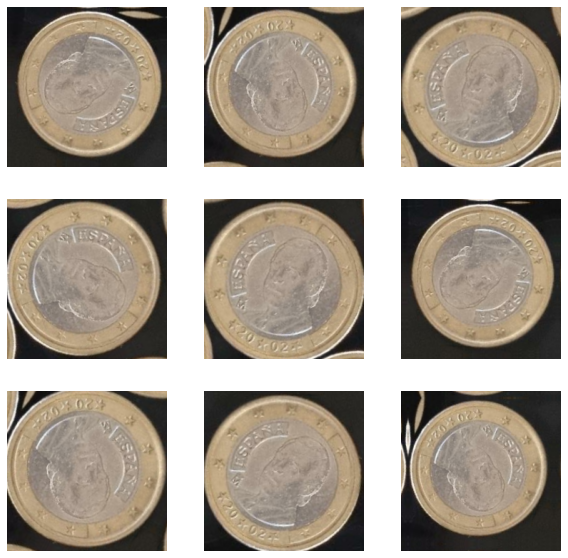

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

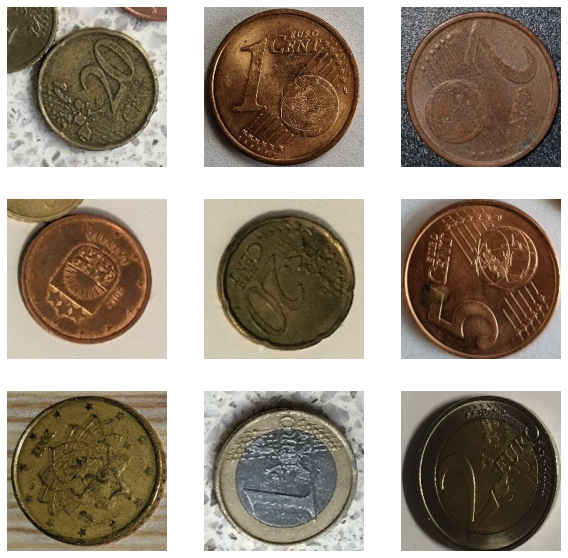

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
lista_modelos = ['ResNet50V2', 'ResNet101V2', 'ResNet152V2', 'VGG16', 'VGG19', 'DenseNet169', 'DenseNet121', 'DenseNet201']
models = []
for model_name in lista_modelos:
    model = get_pretrained_model(model_name)
    model.load_weights(f'/Users/ito/miUpna/Informatica/3/3.1/Vision/3_UPNA_source_code/CoinClassifier/models/{model_name}.hdf5')
    models.append(model)

In [9]:
val_data = {'true': [], 'predicted': []}
error_imgs = []

for images, labels in val_ds.as_numpy_iterator():
    val_predictions = np.zeros_like(labels)
    
    for model in models:
        val_predictions += model.predict(images)
        
    val_predictions = np.argmax(val_predictions, axis= 1)
    
    for index, label in enumerate(labels):
        label = np.argmax(label)
        val_data['true'].append(label)
        val_data['predicted'].append(val_predictions[index])
        if label != val_predictions[index]:
            error_imgs.append((images[index], label, val_predictions[index]))

val_data = pd.DataFrame(val_data)

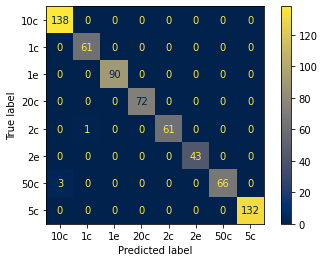

In [ ]:
y_true, y_pred = val_data['true'].values , val_data['predicted'].values

names = ['10c', '1c', '1e', '20c', '2c', '2e', '50c', '5c']

conf_mx = confusion_matrix(y_true , y_pred)

report = classification_report(y_true, y_pred, target_names= names)

ConfusionMatrixDisplay(conf_mx, display_labels= names).plot(cmap= 'cividis')

report

100%|██████████| 4/4 [00:00<00:00, 37.37it/s]


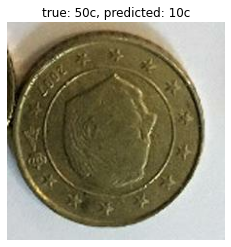

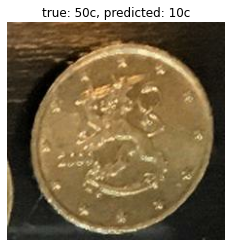

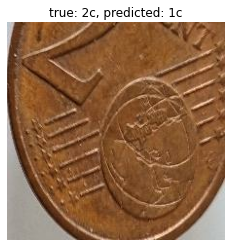

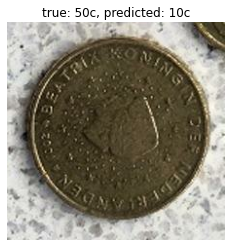

In [11]:
for img, true, pred in tqdm(error_imgs):
    plt.figure()
    plt.title(f"true: {names[true]}, predicted: {names[pred]}")
    plt.imshow(img.astype(np.uint8))
    plt.axis('off')

# Nuevas predicciones

Si se quiere usar el modelo para predecir nuevas imágenes importar las librerias, ejecutar la función get_pretrained_model y la variable data_augmentation (primeras celdas). Finalmente modifica la siguiente línea.

In [10]:
# tiene que ser la ruta a una carpeta con imágenes
IMGS_PATH = '/Users/ito/miUpna/Informatica/3/3.1/Vision/3_UPNA_source_code/CoinClassifier/img/test'

In [11]:
def correccion_ruido(img, th1=250, th2=5):
    
    t_img = img.copy()
    
    gray = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)
    mask1 = gray > th1
    mask2 = gray < th2
    
    img_blur = cv2.medianBlur(t_img, 5)
    
    t_img[mask1] = img_blur[mask1]
    t_img[mask2] = img_blur[mask2]
    
    return t_img

def preprocesamiento_imagen(path, ruido= True, amp_rang_din= True, equalizacion= True):
    img = imread(path)
    if np.all(img == 0) or np.all(img == 255):
        return None
    
    if ruido:
        img = correccion_ruido(img, 230, 20)
    
    if amp_rang_din:
        p0, p100 = np.percentile(img, (0,100))
        img = exposure.rescale_intensity(img, in_range=(p0,p100))

    if equalizacion:
        img = np.uint8(exposure.equalize_adapthist(img, clip_limit=0.003)*255)
    
    img = cv2.resize(img, (224,224), fx=1, fy=1, interpolation= cv2.INTER_CUBIC)

    return img

In [12]:
files = glob(os.path.join(IMGS_PATH, '*.jpg'))

In [13]:
imgs = np.zeros(shape=(1, 224, 224, 3))

for file in tqdm(files):
    img = np.expand_dims(preprocesamiento_imagen(file),0)
    imgs = np.concatenate((imgs, img))

print(imgs.shape)
imgs = imgs[1:,:,:,:]
print(imgs.shape)

100%|██████████| 964/964 [09:39<00:00,  1.66it/s]

(965, 224, 224, 3)
(964, 224, 224, 3)


In [14]:
image_dataset = tf.data.Dataset.from_tensor_slices(imgs)
image_dataset = image_dataset.batch(32)
image_dataset

2022-01-09 11:06:33.765935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float64>

In [18]:
m = len(files)
predictions = np.zeros(shape=(m, 8))

lista_modelos = ['ResNet50V2', 'ResNet101V2', 'ResNet152V2', 'VGG16', 'VGG19', 'DenseNet169', 'DenseNet121', 'DenseNet201']
models = []

for model_name in tqdm(lista_modelos, desc= 'Descarga de modelos'):
    model = get_pretrained_model(model_name)
    model.load_weights(f'/Users/ito/miUpna/Informatica/3/3.1/Vision/3_UPNA_source_code/CoinClassifier/models/{model_name}.hdf5')
    models.append(model)

for model in tqdm(models, desc= 'Generando predicciones'):
    predictions += model.predict(image_dataset)

100%|██████████| 8/8 [16:36<00:00, 124.61s/it]


In [21]:
names = ['10c', '1c', '1e', '20c', '2c', '2e', '50c', '5c']

final_predictions = np.argmax(predictions, axis= 1)

predictions_dict = {"Path": files, "Expected": final_predictions}
predictions_df = pd.DataFrame(predictions_dict)

if IMGS_PATH[-1] != '/':
    folder_len = len(IMGS_PATH) + 1
else:
    folder_len = len(IMGS_PATH) + 2
    
predictions_df['Id'] = predictions_df['Path'].map(lambda x: x[folder_len:])
predictions_df['Label'] = predictions_df['Expected'].map(lambda x: names[x])

predictions_df = predictions_df[['Path', 'Id', 'Label', 'Expected']]

predictions_df.head()

,Path,Id,Label,Expected
0,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,IMG_92242261297b-5360-11ec-b9c5-ec2e98cc05dc.jpg,5c,7
1,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,IMG_854221d6ad24-5360-11ec-bdf6-ec2e98cc05dc.jpg,20c,3
2,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,IMG_358521a20574-5360-11ec-903f-ec2e98cc05dc.jpg,1e,2
3,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,IMG_3209213d1e04-5360-11ec-8089-ec2e98cc05dc.jpg,2c,4
4,/Users/ito/miUpna/Informatica/3/3.1/Vision/3_U...,IMG_644221ab74c3-5360-11ec-9be6-ec2e98cc05dc.jpg,20c,3


In [22]:
# predictions_df[['Id', 'Expected']].to_csv("predictions.csv", index= False)